In [1]:
import torch
import torch.nn as nn
import gym
import numpy as np
import random
import torch.nn.functional as F
from ops import *
from models import *
%matplotlib inline
import matplotlib.pyplot as plt
import random
import time
import functools
import math

envs = ['CartPole-v1','Acrobot-v1','MountainCar-v0','Pendulum-v0','BipedalWalker-v2','LunarLander-v2']
env_to_use = 0

discrete_actions = True

env = gym.make(envs[env_to_use]).unwrapped
if discrete_actions:
    creature_out_size = env.action_space.n
else:
    creature_out_size = env.action_space.shape[0]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

lr = 0.01

In [2]:
def train_gan(pop,p_fitness,population_size,batch_size = 20,n_epochs = 100):
    p_fitness = torch.from_numpy(p_fitness).type("torch.FloatTensor").to(device)
    
    gen_explore_all = []
    gen_exploit_all = []
    dis_loss_all = []
    dis_confidence_all = []
    for e in range(n_epochs):
        #shuffle arrays in unison
        ind = np.arange(population_size)
        np.random.shuffle(ind)
        pop = pop[ind]
        p_fitness = p_fitness[ind]
        for i in range(population_size//batch_size):
            #turn population into vectors
            p_batch = pop[i*batch_size:(i*batch_size)+batch_size].detach()
            f_batch = p_fitness[i*batch_size:(i*batch_size)+batch_size].detach()
            
            #train discriminator on population
            dis_optimizer.zero_grad()
            
            dis_out_r,_ = dis(p_batch)
            dis_out_r = dis_out_r.squeeze(-1)
            
            dis_error_real = (torch.pow((dis_out_r[...,0]-f_batch),2))
            dis_error_real_mean = torch.mean(dis_error_real)
            dis_error_real_mean.backward(retain_graph=True)
            
            #discriminator confidence in its prediction
            dis_confidence = torch.mean(torch.pow(dis_out_r[...,1]-dis_error_real.detach(),2))
            dis_confidence.backward()
            
            dis_optimizer.step() 
            dis_loss_all.append(dis_error_real_mean)  
            dis_confidence_all.append(torch.mean(dis_out_r[...,1]))
            
        #if False:
        for i in range(population_size//batch_size):
            gen.hidden = None
            gen_optimizer.zero_grad()
            gen_out = gen(p_batch,lr)
            
            #gen_out = []
            #for p in p_batch:
                #gen_out.append(gen(p.unsqueeze(0),lr))
                
            #gen_out = torch.cat(gen_out,0).to(device)
            
            dis_out_f,dis_out_latent = dis(p_batch + gen_out)
            
            #define generator loss
            variety = -torch.mean(torch.std(dis_out_latent,-1))#-torch.std(dis_out_f[...,0])
            
            gen_error_exploration = (variety)-torch.mean(dis_out_f[...,1])
            gen_error_exploitation = -torch.mean(dis_out_f[...,0]) 
            gen_error =  gen_error_exploitation + gen_error_exploration
            
            gen_error.backward()
            gen_optimizer.step() 
            
            gen_explore_all.append(gen_error_exploration)
            gen_exploit_all.append(gen_error_exploitation)
            gen.hidden = None
            
    print(f_batch)
    print(dis_out_r[...,0])   
    
    return gen_explore_all,gen_exploit_all, dis_loss_all,dis_confidence_all

starting training
386
Measured population fitness : 0s
population fitness : [70.  8. 10. 10. 10.]
mean fit : 21.6
tensor([-0.3914, -0.3914, -0.4458, -0.3914,  1.0983], device='cuda:0')
tensor([-0.4070, -0.4062, -0.4601, -0.4053,  1.0844],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


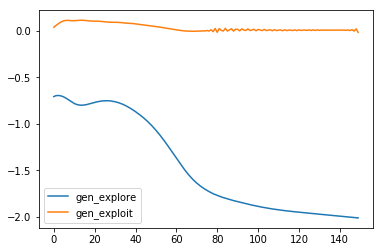

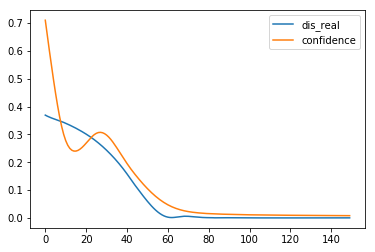

Generation 1  fitness : 70.0
#################################
Measured population fitness : 0s
population fitness : [69.  9. 10.  9. 10.]
mean fit : 21.4
tensor([-0.3914, -0.3914,  1.1053,  1.0914, -0.3914], device='cuda:0')
tensor([-0.4072, -0.3935,  1.0960,  1.0960, -0.3951],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


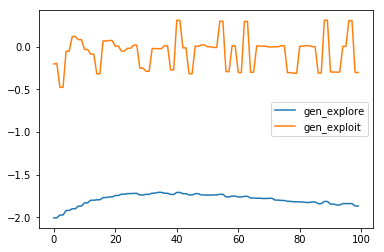

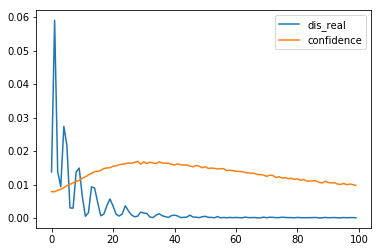

Generation 2  fitness : 69.0
#################################
Measured population fitness : 0s
population fitness : [39. 10.  8. 10. 11.]
mean fit : 15.6
tensor([-0.4077,  1.2130, -0.3754, -0.3754, -0.4390], device='cuda:0')
tensor([-0.4008,  0.9211, -0.4008, -0.3751, -0.4203],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


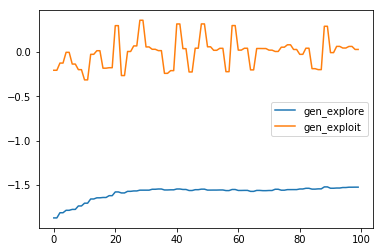

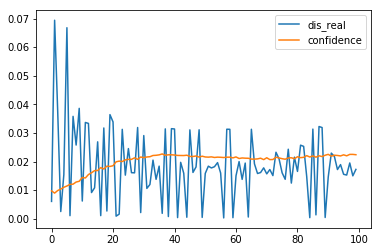

Generation 3  fitness : 39.0
#################################
Measured population fitness : 0s
population fitness : [43. 10.  9. 10. 10.]
mean fit : 16.4
tensor([-0.3730, -0.3730, -0.4080,  0.8122, -0.3730], device='cuda:0')
tensor([-0.3852, -0.3673, -0.4368,  0.7501, -0.3861],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


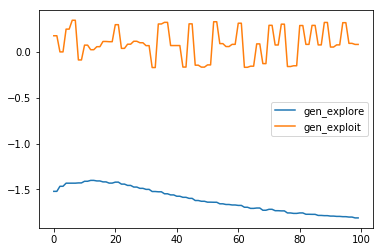

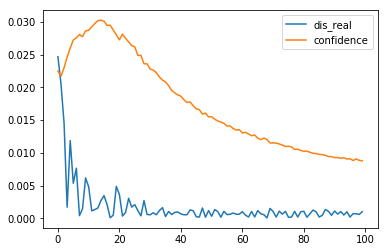

Generation 4  fitness : 43.0
#################################
Measured population fitness : 0s
population fitness : [29. 10.  9.  9. 10.]
mean fit : 13.4
tensor([-0.3589, -0.3974,  0.4925, -0.3589, -0.3589], device='cuda:0')
tensor([-0.3599, -0.3992,  0.6871, -0.3597, -0.3782],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


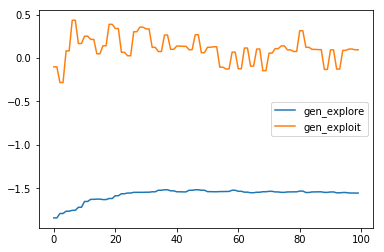

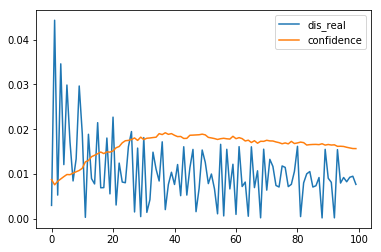

Generation 5  fitness : 29.0
#################################
Measured population fitness : 0s
population fitness : [18. 10. 10. 10.  9.]
mean fit : 11.4
tensor([-0.3386, -0.3809, -0.3809, -0.3809, -0.3386], device='cuda:0')
tensor([-0.3749, -0.3785, -0.3749, -0.3731, -0.3785],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


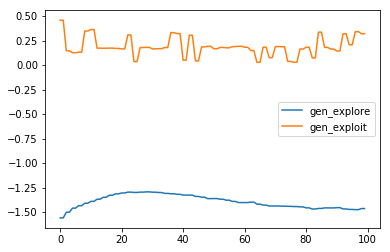

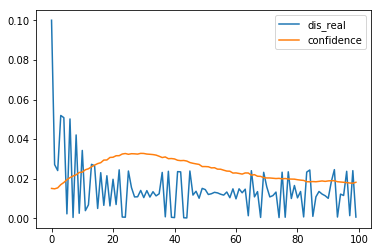

Generation 6  fitness : 18.0
#################################
Measured population fitness : 0s
population fitness : [21.  9. 10. 10. 10.]
mean fit : 12.0
tensor([-0.3730, -0.3273, -0.3273,  0.1236, -0.3273], device='cuda:0')
tensor([-0.3166, -0.2959, -0.2957,  0.2386, -0.2959],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


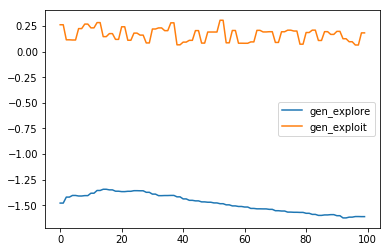

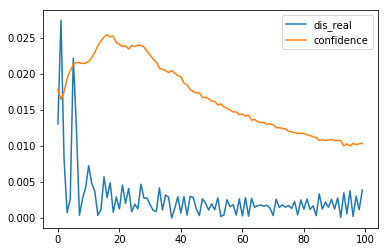

Generation 7  fitness : 21.0
#################################
Measured population fitness : 0s
population fitness : [13.  8.  9. 10.  9.]
mean fit : 9.8
tensor([-0.3050, -0.3050, -0.3050, -0.3543, -0.3050], device='cuda:0')
tensor([-0.3422, -0.3626, -0.3422, -0.4080, -0.3630],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


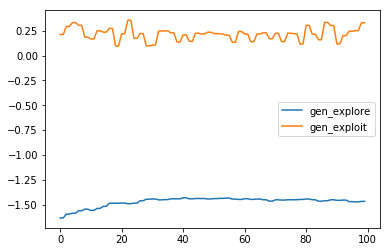

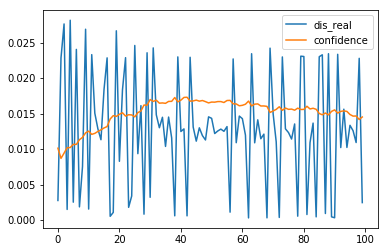

Generation 8  fitness : 13.0
#################################
Measured population fitness : 0s
population fitness : [17.  8.  8.  9.  9.]
mean fit : 10.2
tensor([-0.3910, -0.3910, -0.3411,  0.1567, -0.3411], device='cuda:0')
tensor([-0.3966, -0.3966, -0.3223,  0.0163, -0.3483],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


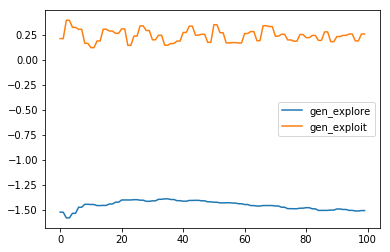

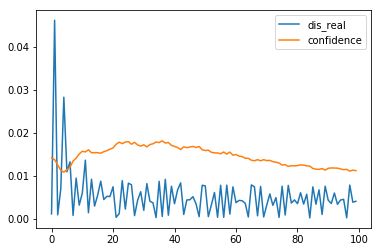

Generation 9  fitness : 17.0
#################################
Measured population fitness : 0s
population fitness : [11. 10. 10. 10.  9.]
mean fit : 10.0
tensor([-0.2742, -0.2742, -0.3829, -0.2742, -0.3300], device='cuda:0')
tensor([-0.3299, -0.2965, -0.3299, -0.3262, -0.2965],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


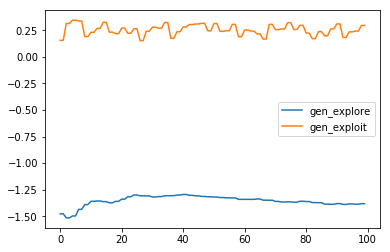

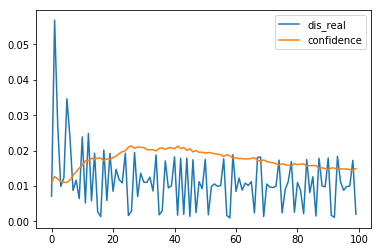

Generation 10  fitness : 11.0
#################################
Measured population fitness : 0s
population fitness : [15.  9. 10.  9.  9.]
mean fit : 10.4
tensor([-0.3227, -0.3227, -0.2016, -0.2640, -0.2640], device='cuda:0')
tensor([-0.3125, -0.3125, -0.0407, -0.2821, -0.2551],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


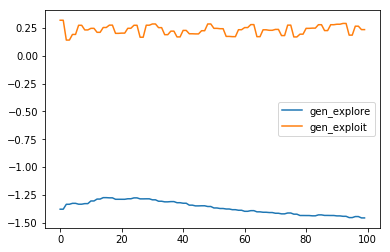

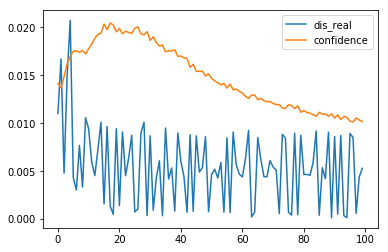

Generation 11  fitness : 15.0
#################################
Measured population fitness : 0s
population fitness : [15. 10.  9.  8.  9.]
mean fit : 10.2
tensor([ 0.1134, -0.2540, -0.3155,  0.1134, -0.2540], device='cuda:0')
tensor([ 0.1047, -0.2916, -0.3514,  0.1047, -0.2932],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


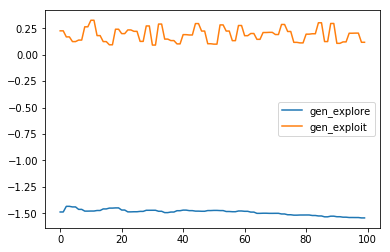

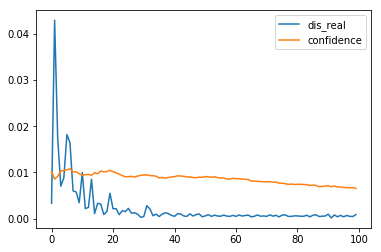

Generation 12  fitness : 15.0
#################################
Measured population fitness : 0s
population fitness : [12.  9.  9.  9.  8.]
mean fit : 9.4
tensor([-0.3055, -0.3055, -0.3055, -0.2410, -0.3661], device='cuda:0')
tensor([-0.3414, -0.3419, -0.3124, -0.2781, -0.3414],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


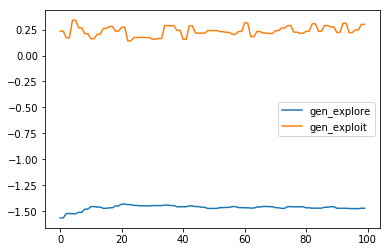

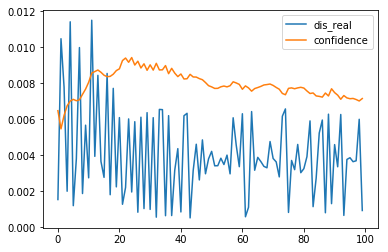

Generation 13  fitness : 12.0
#################################
Measured population fitness : 0s
population fitness : [16. 11. 10.  9.  9.]
mean fit : 11.0
tensor([-0.3044, -0.1658, -0.3044,  0.2296, -0.3044], device='cuda:0')
tensor([-0.2419, -0.2419, -0.2770,  0.0590, -0.3095],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


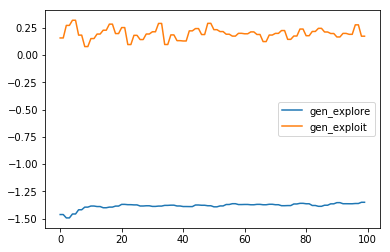

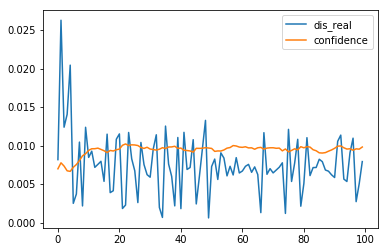

Generation 14  fitness : 16.0
#################################
Measured population fitness : 0s
population fitness : [13. 14. 10.  9.  9.]
mean fit : 11.0
tensor([-0.3038,  0.2460, -0.3038, -0.2346,  0.0933], device='cuda:0')
tensor([-0.3137,  0.1221, -0.3134, -0.2463, -0.0394],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


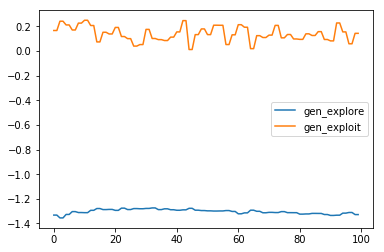

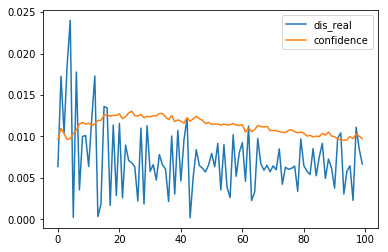

Generation 15  fitness : 14.0
#################################
Measured population fitness : 0s
population fitness : [13. 10. 12.  9. 10.]
mean fit : 10.8
tensor([-0.2313,  0.0196, -0.2313, -0.0709,  0.1072], device='cuda:0')
tensor([-0.0719,  0.0087, -0.1604, -0.1604, -0.0719],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


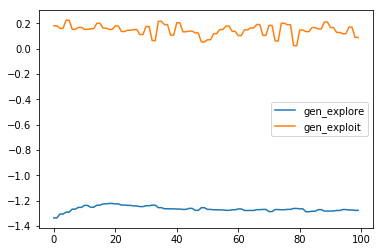

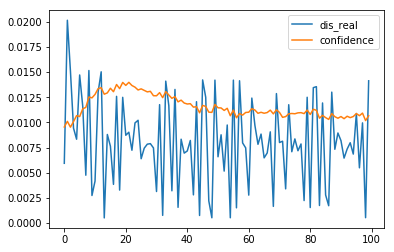

Generation 16  fitness : 13.0
#################################
Measured population fitness : 0s
population fitness : [11. 13. 14.  9. 10.]
mean fit : 11.4
tensor([-0.2311,  0.0279, -0.3046,  0.1172, -0.3046], device='cuda:0')
tensor([-0.0913, -0.0511, -0.2895,  0.0352, -0.2895],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


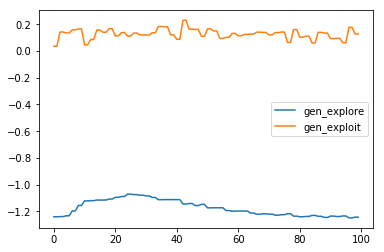

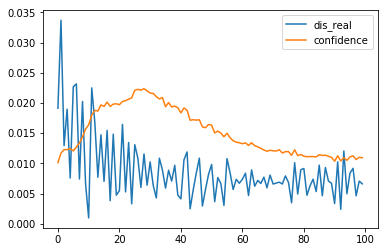

Generation 17  fitness : 14.0
#################################
Measured population fitness : 0s
population fitness : [12. 11. 12.  9. 10.]
mean fit : 10.8
tensor([-0.2285,  0.0387, -0.1467, -0.0576,  0.1295], device='cuda:0')
tensor([-0.2272, -0.0549, -0.0549, -0.1005,  0.0318],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


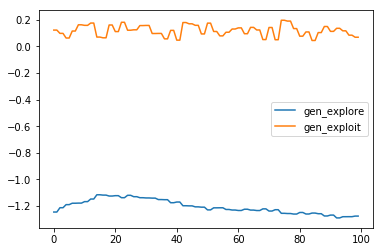

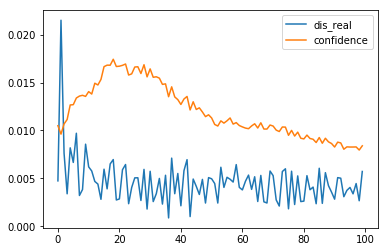

Generation 18  fitness : 12.0
#################################
Measured population fitness : 0s
population fitness : [13. 17. 12.  9. 10.]
mean fit : 12.2
tensor([-0.0570,  0.3699, -0.1483, -0.2320,  0.0417], device='cuda:0')
tensor([-0.0090,  0.1123,  0.1123, -0.2343, -0.0090],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


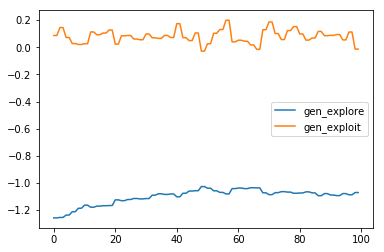

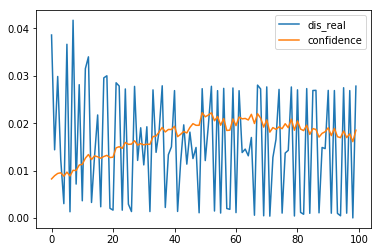

Generation 19  fitness : 17.0
#################################
Measured population fitness : 0s
population fitness : [17. 13.  8.  9. 10.]
mean fit : 11.4
tensor([ 0.3811, -0.3839, -0.2319,  0.3811, -0.0524], device='cuda:0')
tensor([ 0.1845, -0.2450, -0.2577,  0.1857, -0.2450],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


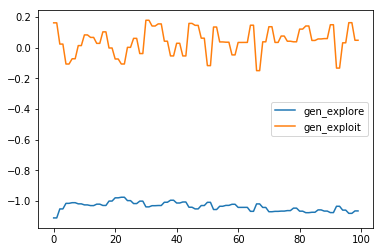

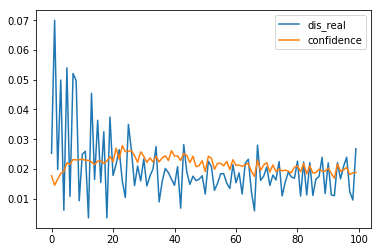

Generation 20  fitness : 17.0
#################################
Measured population fitness : 0s
population fitness : [18. 13.  9. 10. 10.]
mean fit : 12.0
tensor([ 0.0520, -0.3146, -0.2343, -0.2343,  0.3897], device='cuda:0')
tensor([ 0.0653, -0.2648, -0.2235, -0.2235,  0.4362],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


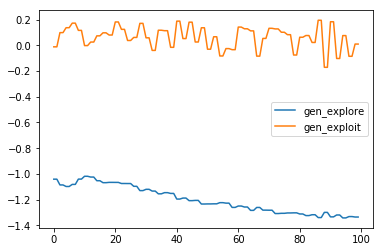

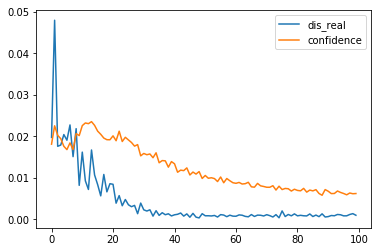

Generation 21  fitness : 18.0
#################################
Measured population fitness : 0s
population fitness : [21. 14. 10. 10.  9.]
mean fit : 12.8
tensor([-0.2392, -0.2392, -0.2392, -0.3206, -0.2392], device='cuda:0')
tensor([-0.2522, -0.2522, -0.2943, -0.2938, -0.2938],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


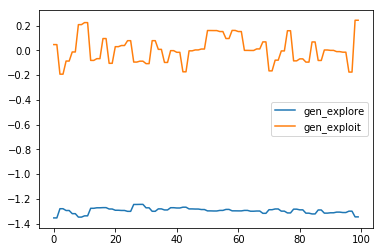

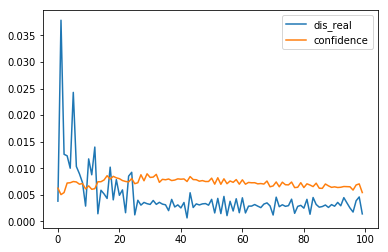

Generation 22  fitness : 21.0
#################################
Measured population fitness : 0s
population fitness : [19. 14. 10.  9.  9.]
mean fit : 12.2
tensor([-0.3246, -0.2420, -0.3246, -0.2420, -0.2420], device='cuda:0')
tensor([-0.3419, -0.3021, -0.3419, -0.2604, -0.2604],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


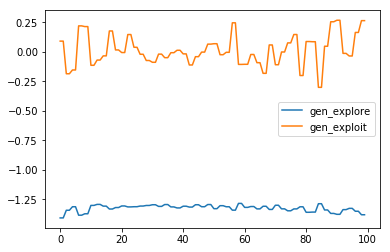

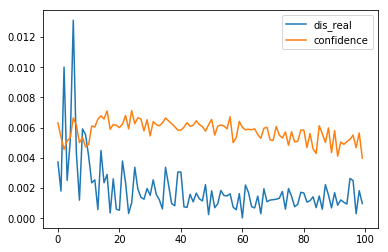

Generation 23  fitness : 19.0
#################################
Measured population fitness : 0s
population fitness : [22. 16.  8. 10.  9.]
mean fit : 13.0
tensor([-0.2468, -0.3302, -0.3302, -0.4071,  0.3275], device='cuda:0')
tensor([-0.3009, -0.3432, -0.3009, -0.3384,  0.2233],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


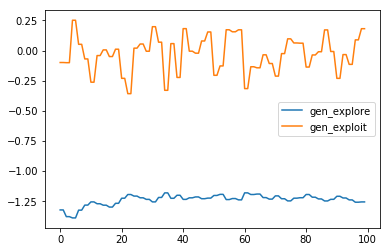

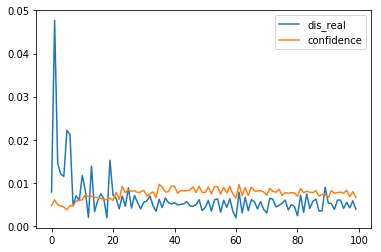

Generation 24  fitness : 22.0
#################################
Measured population fitness : 0s
population fitness : [23. 18. 11.  9.  9.]
mean fit : 14.0
tensor([-0.3383, -0.1633,  0.7231, -0.2546,  0.4766], device='cuda:0')
tensor([-0.3048, -0.2966,  0.7427, -0.3048,  0.3929],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


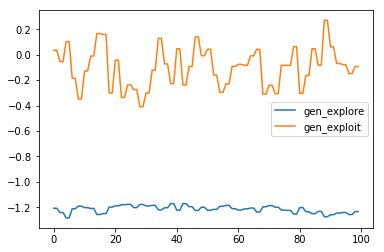

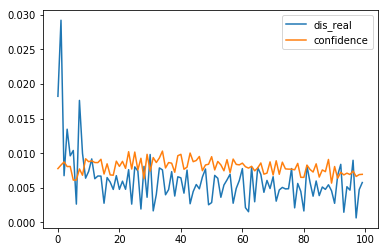

Generation 25  fitness : 23.0
#################################
Measured population fitness : 0s
population fitness : [30. 24. 11. 10. 10.]
mean fit : 17.0
tensor([-0.3511,  1.0775,  0.8170, -0.3511,  0.4637], device='cuda:0')
tensor([-0.3210,  0.9075,  0.6291, -0.3214,  0.6291],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


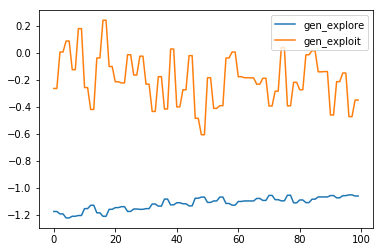

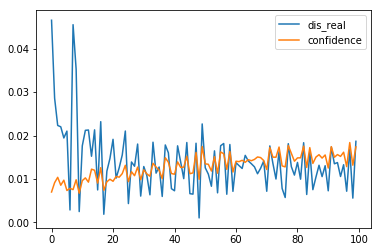

Generation 26  fitness : 30.0
#################################
Measured population fitness : 0s
population fitness : [30. 17. 14. 10.  9.]
mean fit : 16.0
tensor([ 0.8125,  1.0747, -0.2797,  0.3821, -0.1908], device='cuda:0')
tensor([ 0.6201,  1.1035, -0.3010,  0.6201, -0.0144],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


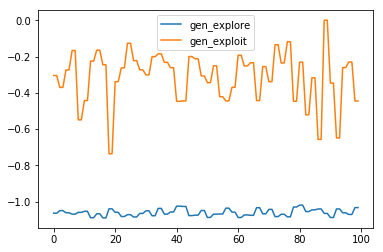

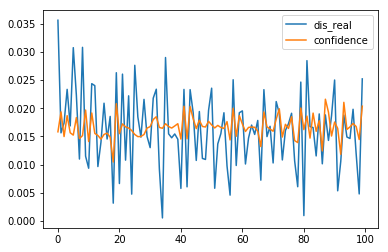

Generation 27  fitness : 30.0
#################################
Measured population fitness : 0s
population fitness : [27. 20. 13. 10.  9.]
mean fit : 15.8
tensor([ 1.0744, -0.2900,  0.0032, -0.3713,  0.5855], device='cuda:0')
tensor([ 0.9741, -0.3275,  0.0187, -0.4102,  0.4420],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


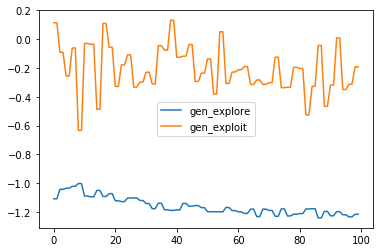

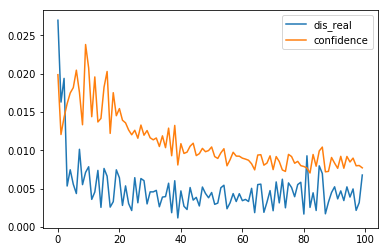

Generation 28  fitness : 27.0
#################################
Measured population fitness : 0s
population fitness : [31. 20. 15. 10.  8.]
mean fit : 16.8
tensor([ 0.9447,  0.5767, -0.3009, -0.3009,  0.5767], device='cuda:0')
tensor([ 1.0372,  0.5849, -0.2892, -0.2892,  0.5849],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


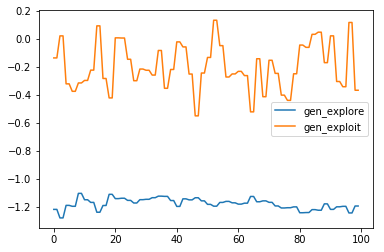

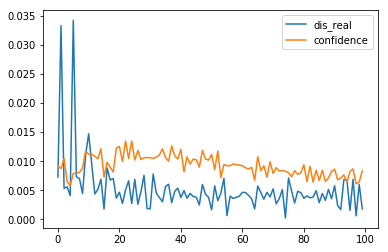

Generation 29  fitness : 31.0
#################################
Measured population fitness : 0s
population fitness : [39. 15. 14.  9.  8.]
mean fit : 17.0
tensor([0.1799, 0.0821, 1.3547, 0.5625, 1.0928], device='cuda:0')
tensor([0.1329, 0.1329, 1.2212, 0.3765, 1.2212],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


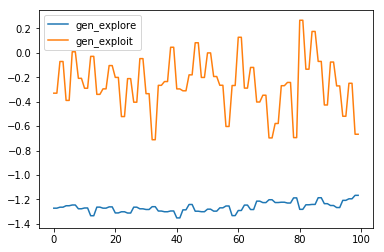

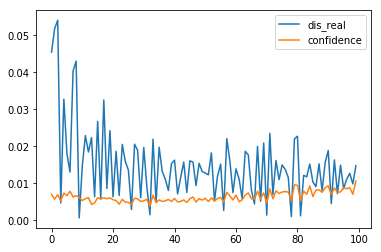

Generation 30  fitness : 39.0
#################################
Measured population fitness : 0s
population fitness : [37. 12. 15. 10. 10.]
mean fit : 16.8
tensor([-0.3155,  1.3458,  0.1680,  1.2864,  0.1680], device='cuda:0')
tensor([-0.4148,  1.2864,  0.0926,  1.2864, -0.0082],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


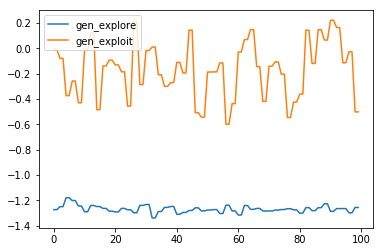

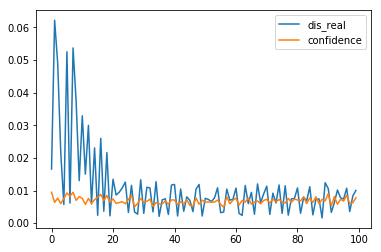

Generation 31  fitness : 37.0
#################################
Measured population fitness : 0s
population fitness : [52. 16. 20.  9. 10.]
mean fit : 21.4
tensor([ 1.6246,  0.2270, -0.3236,  1.2482,  0.1386], device='cuda:0')
tensor([ 1.4060,  0.0027, -0.3554,  1.4060,  0.3012],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


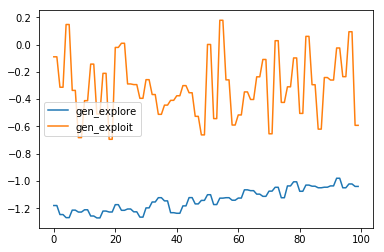

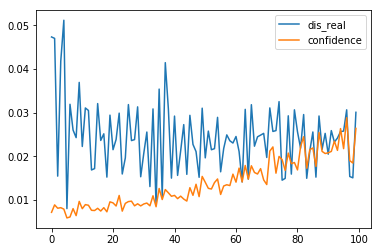

Generation 32  fitness : 52.0
#################################
Measured population fitness : 0s
population fitness : [72. 12. 18. 10.  9.]
mean fit : 24.2
tensor([-0.1704,  0.3325,  0.4623, -0.3892,  1.5437], device='cuda:0')
tensor([ 0.0016,  0.3928,  0.3928, -0.3637,  1.7154],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


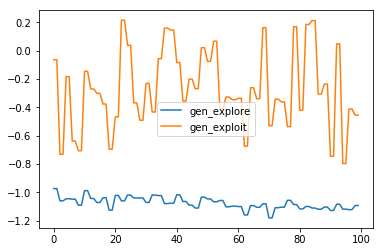

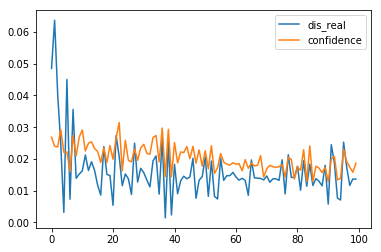

Generation 33  fitness : 72.0
#################################
Measured population fitness : 0s
population fitness : [100.  11.  18.   8.  10.]
mean fit : 29.4
tensor([ 0.2610, -0.2452,  2.0853,  1.7479, -0.4219], device='cuda:0')
tensor([ 0.2537, -0.2232,  1.8999,  1.8999, -0.3744],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


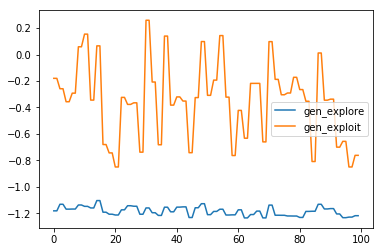

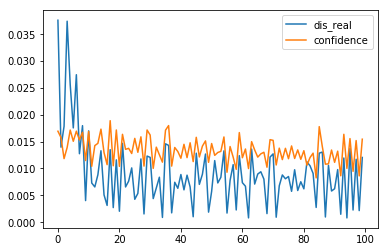

Generation 34  fitness : 100.0
#################################
Measured population fitness : 0s
population fitness : [126.  14.  18.   9.   9.]
mean fit : 35.2
tensor([-0.3419,  2.1492, -0.3892,  1.9174, -0.2399], device='cuda:0')
tensor([-0.3188,  2.0367, -0.3638,  2.0367, -0.1524],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


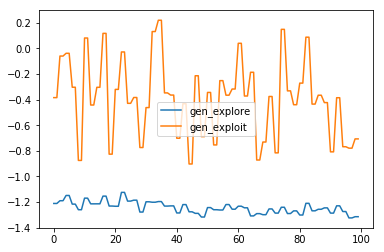

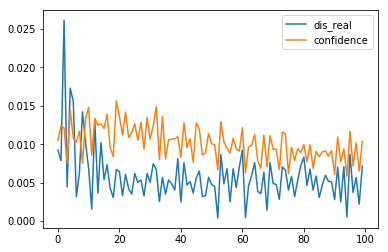

Generation 35  fitness : 126.0
#################################
Measured population fitness : 0s
population fitness : [134.  15.  24.  11.  10.]
mean fit : 38.8
tensor([-0.3301,  2.0768,  0.4010, -0.2868, -0.0367], device='cuda:0')
tensor([-0.3111,  2.0199,  0.2406, -0.3328, -0.0904],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


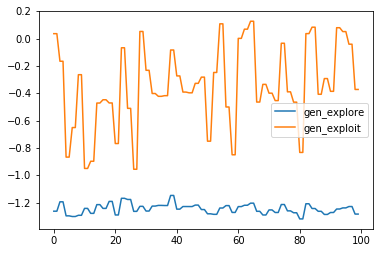

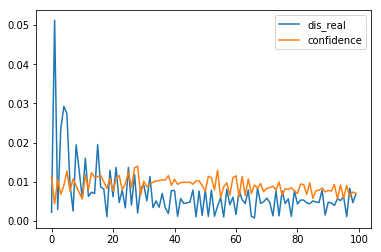

Generation 36  fitness : 134.0
#################################
Measured population fitness : 0s
population fitness : [142.  10.  21.   9.  10.]
mean fit : 38.4
tensor([-0.0632,  0.2217,  1.9672, -0.2423,  0.3399], device='cuda:0')
tensor([-0.1755,  0.2792,  1.9914, -0.2844,  0.2792],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


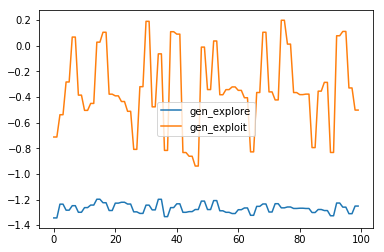

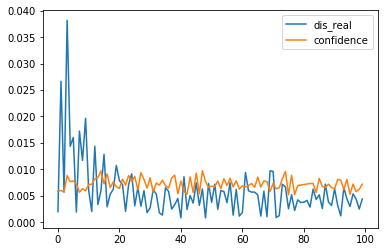

Generation 37  fitness : 142.0
#################################
Measured population fitness : 0s
population fitness : [144.  13.  26.  10.   9.]
mean fit : 40.4
tensor([ 1.9511, -0.2829,  0.1785, -0.1693, -0.2829], device='cuda:0')
tensor([ 1.9358, -0.2356,  0.2623, -0.2356, -0.3097],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


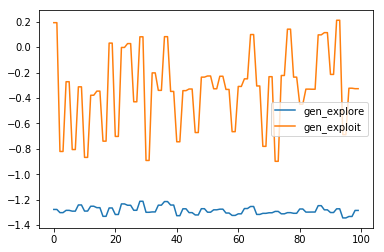

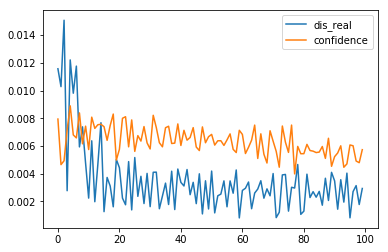

Generation 38  fitness : 144.0
#################################
Measured population fitness : 0s
population fitness : [132.  11.  34.  12.  10.]
mean fit : 39.8
tensor([-0.2879, -0.2186,  0.3226, -0.3208,  1.8944], device='cuda:0')
tensor([-0.3291, -0.2747,  0.4139, -0.3291,  1.8272],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


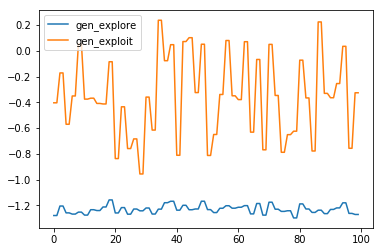

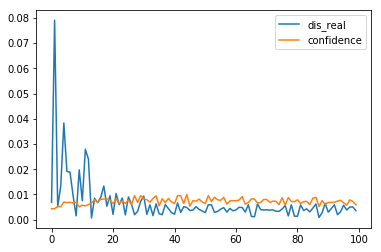

Generation 39  fitness : 132.0
#################################
Measured population fitness : 0s
population fitness : [94. 10. 27. 14. 10.]
mean fit : 31.0
tensor([-0.2947,  0.5367,  1.4686, -0.2614,  0.3388], device='cuda:0')
tensor([-0.2847,  0.4525,  1.6473, -0.2639,  0.4525],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


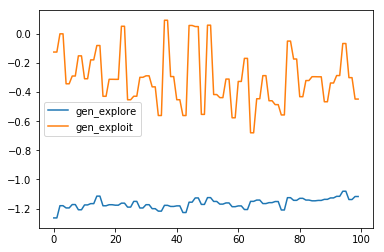

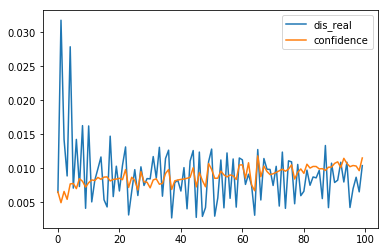

Generation 40  fitness : 94.0
#################################
Measured population fitness : 0s
population fitness : [108.  11.  36.  12.  11.]
mean fit : 35.6
tensor([ 1.4433, -0.2695, -0.2695,  0.5643, -0.2363], device='cuda:0')
tensor([ 1.5163, -0.2794, -0.2788,  0.4428, -0.1943],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


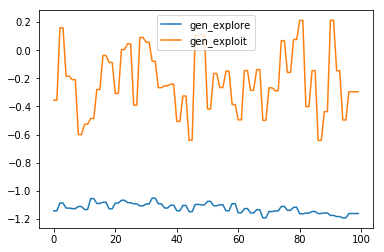

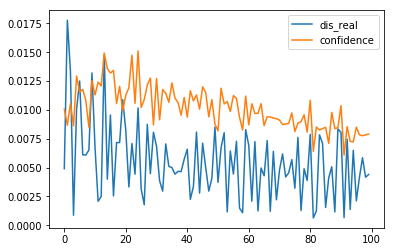

Generation 41  fitness : 108.0
#################################
Measured population fitness : 0s
population fitness : [66. 16. 32. 31.  9.]
mean fit : 30.8
tensor([ 1.1075, -0.2792,  0.4541,  1.5729,  0.5571], device='cuda:0')
tensor([ 1.3701, -0.2846,  0.5284,  1.3701,  0.5284],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


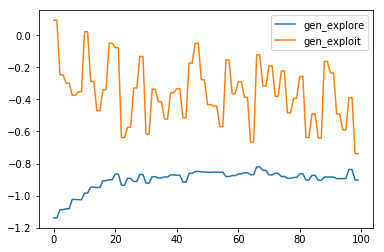

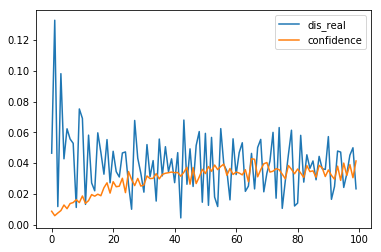

Generation 42  fitness : 66.0
#################################
Measured population fitness : 0s
population fitness : [51. 14. 27. 27. 10.]
mean fit : 25.8
tensor([ 0.3047, -0.3180, -0.1102,  0.4240,  0.8703], device='cuda:0')
tensor([ 0.3625, -0.3472, -0.1644,  0.3482,  0.9707],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


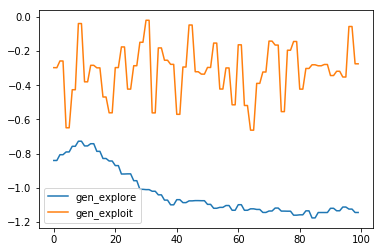

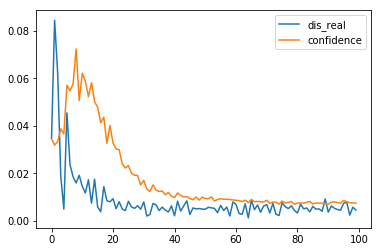

Generation 43  fitness : 51.0
#################################
Measured population fitness : 0s
population fitness : [56. 12. 42. 32.  9.]
mean fit : 30.2
tensor([ 0.2969, -0.2625,  0.8667,  0.9533,  0.2969], device='cuda:0')
tensor([ 0.5035, -0.2152,  0.9210,  0.9210,  0.3818],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


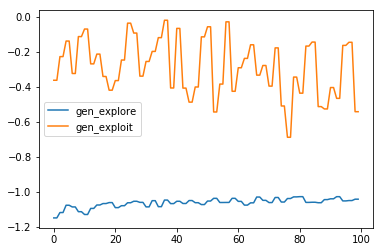

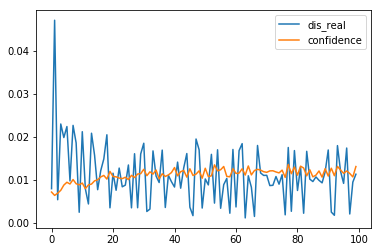

Generation 44  fitness : 56.0
#################################
Measured population fitness : 0s
population fitness : [65. 17. 31. 29. 10.]
mean fit : 30.4
tensor([-0.0917,  0.9498,  0.3516,  0.6839, -0.3348], device='cuda:0')
tensor([-0.2015,  1.0001,  0.3799,  0.5305, -0.3679],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


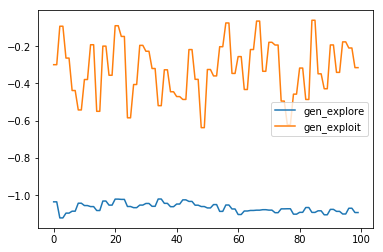

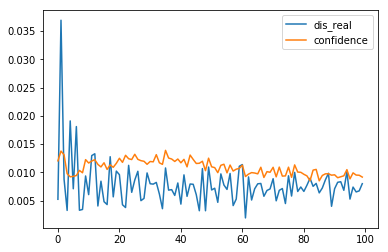

Generation 45  fitness : 65.0
#################################
Measured population fitness : 0s
population fitness : [51. 13. 37. 49.  9.]
mean fit : 31.8
tensor([-0.1025,  0.3437, -0.3738,  1.0866,  0.8586], device='cuda:0')
tensor([-0.1862,  0.5791, -0.3708,  0.9667,  0.9667],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


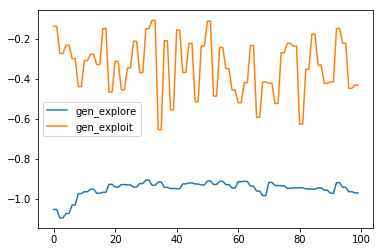

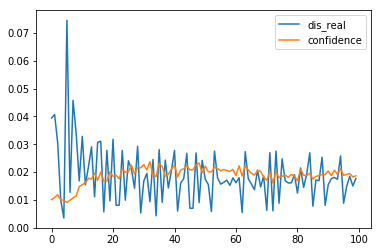

Generation 46  fitness : 51.0
#################################
Measured population fitness : 0s
population fitness : [81. 16. 36. 40.  9.]
mean fit : 36.4
tensor([ 0.8103, -0.3821,  0.6222, -0.2577,  0.5257], device='cuda:0')
tensor([ 0.7136, -0.3737,  0.7136, -0.1972,  0.5381],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


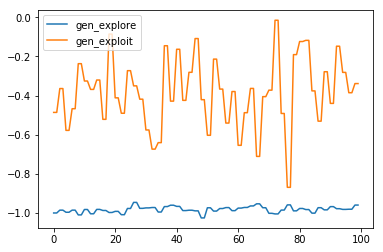

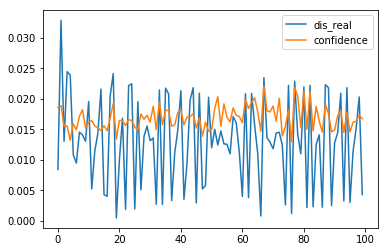

Generation 47  fitness : 81.0
#################################
Measured population fitness : 0s
population fitness : [55. 15. 58. 42. 10.]
mean fit : 36.0
tensor([-0.1650,  0.9618,  1.2809,  0.6587, -0.3618], device='cuda:0')
tensor([-0.1975,  0.7237,  1.0767,  0.6194, -0.3887],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


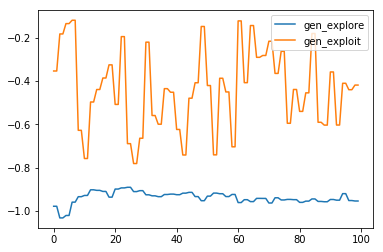

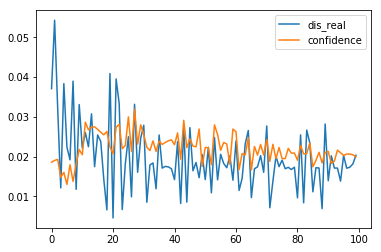

Generation 48  fitness : 58.0
#################################
Measured population fitness : 0s
population fitness : [50. 19. 88. 34.  9.]
mean fit : 40.0
tensor([ 0.8079,  0.8979,  0.4489, -0.2125,  0.9483], device='cuda:0')
tensor([ 0.8688,  0.8688,  0.5567, -0.1305,  1.1586],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


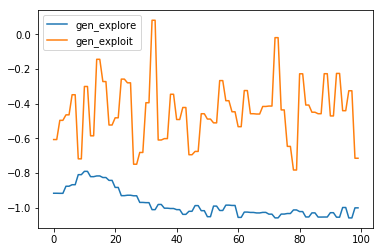

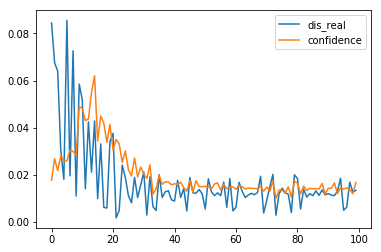

Generation 49  fitness : 88.0
#################################
Measured population fitness : 0s
population fitness : [ 42.  16. 130.  97.   8.]
mean fit : 58.6
tensor([ 0.6032,  1.3949,  1.3011,  1.6787, -0.0905], device='cuda:0')
tensor([ 0.6283,  0.8675,  1.4383,  1.4383, -0.1885],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


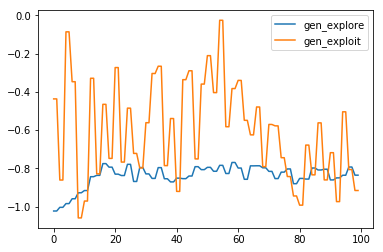

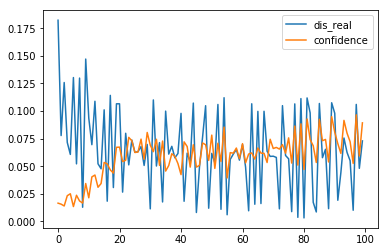

Generation 50  fitness : 130.0
#################################
Measured population fitness : 0s
population fitness : [  53.   15. 2000.   59.   10.]
mean fit : 427.4
tensor([ 0.0958, -0.1075, -0.1562,  0.5868, -0.1425], device='cuda:0')
tensor([ 0.1677, -0.1117, -0.1543,  1.7243, -0.1543],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


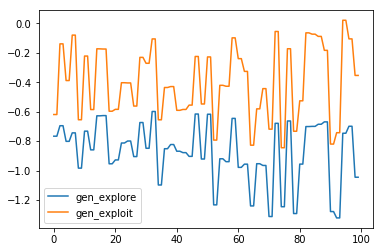

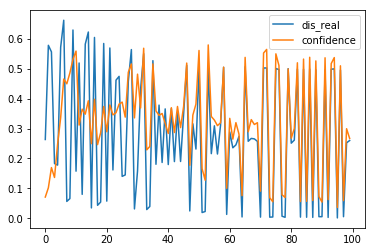

Generation 51  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [54. 20. 98. 86. 11.]
mean fit : 53.8
tensor([-0.1400, -0.1469,  0.1702,  0.1770,  0.4353], device='cuda:0')
tensor([-0.1336, -0.1336,  0.1858,  0.1858,  1.6490],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


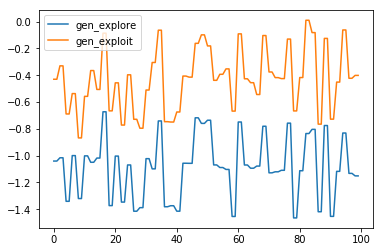

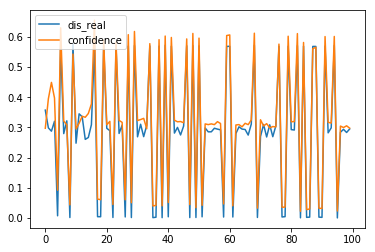

Generation 52  fitness : 98.0
#################################
Measured population fitness : 0s
population fitness : [54. 16. 79. 72.  9.]
mean fit : 46.0
tensor([-0.1433,  0.2912,  0.1763,  0.3723,  0.4369], device='cuda:0')
tensor([-0.1502,  0.3019,  0.1706,  0.3019,  0.4030],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


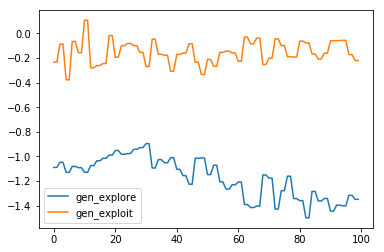

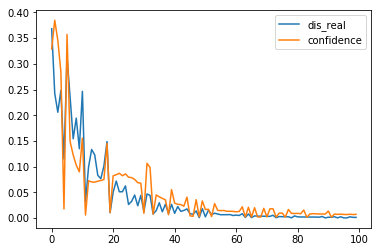

Generation 53  fitness : 79.0
#################################
Measured population fitness : 0s
population fitness : [44. 15. 85. 48. 10.]
mean fit : 40.4
tensor([-0.1100,  0.3340,  0.2923, -0.1173, -0.1528], device='cuda:0')
tensor([-0.1236,  0.3413,  0.2054, -0.1236, -0.1635],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


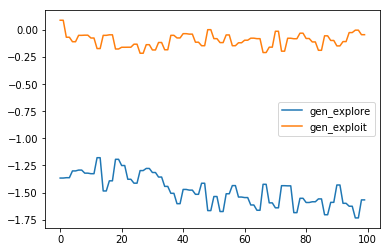

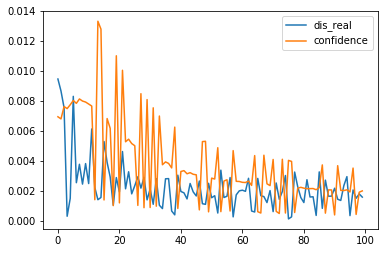

Generation 54  fitness : 85.0
#################################
Measured population fitness : 0s
population fitness : [40. 18. 67. 90. 10.]
mean fit : 45.0
tensor([-0.1559,  0.3694,  0.3974,  0.0747, -0.1559], device='cuda:0')
tensor([-0.1734,  0.3011,  0.2481,  0.0704, -0.1734],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


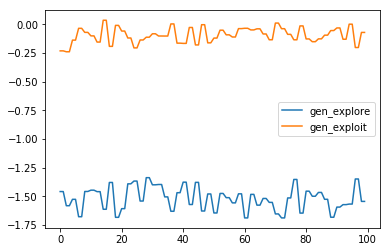

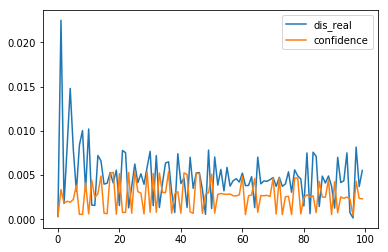

Generation 55  fitness : 90.0
#################################
Measured population fitness : 0s
population fitness : [53. 18. 75. 36.  8.]
mean fit : 38.0
tensor([ 0.0743, -0.0999, -0.1722,  0.2629,  0.3125], device='cuda:0')
tensor([ 0.1242, -0.0981, -0.1624,  0.2894,  0.2894],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


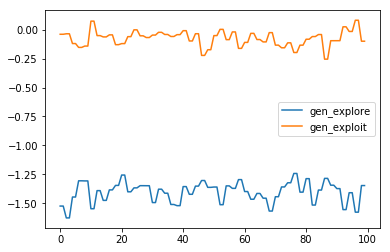

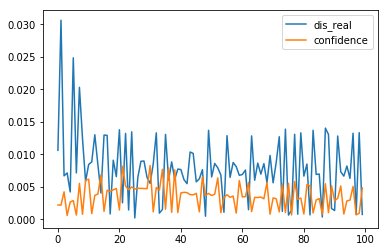

Generation 56  fitness : 75.0
#################################
Measured population fitness : 0s
population fitness : [42. 18. 59. 68.  9.]
mean fit : 39.2
tensor([-0.1018,  0.2703,  0.0422,  0.1698, -0.1675], device='cuda:0')
tensor([-0.1031,  0.1563,  0.1563,  0.1296, -0.1727],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


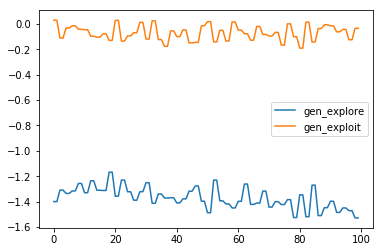

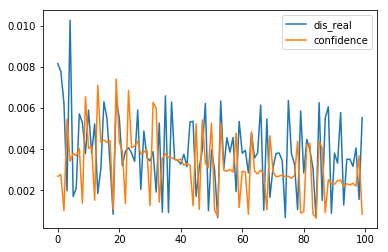

Generation 57  fitness : 68.0
#################################
Measured population fitness : 0s
population fitness : [40. 29. 43. 77. 10.]
mean fit : 39.8
tensor([ 0.0963,  0.3274,  0.0731, -0.0166, -0.1038], device='cuda:0')
tensor([ 0.1561,  0.2995,  0.0823, -0.0590, -0.0590],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


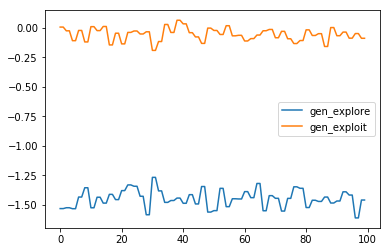

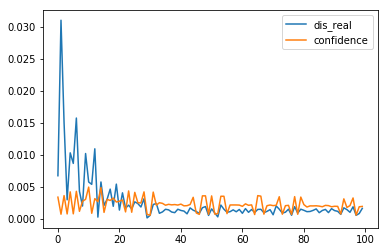

Generation 58  fitness : 77.0
#################################
Measured population fitness : 0s
population fitness : [52. 18. 44. 52.  9.]
mean fit : 35.0
tensor([ 0.1636,  0.1636, -0.0173,  0.3294,  0.0732], device='cuda:0')
tensor([ 0.2454,  0.1139, -0.0650,  0.2454,  0.1139],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


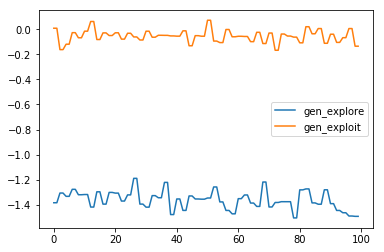

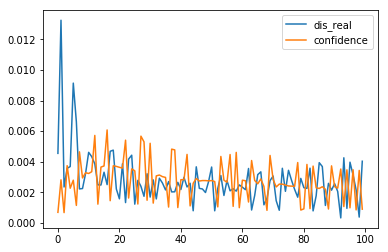

Generation 59  fitness : 52.0
#################################
Measured population fitness : 0s
population fitness : [95. 26. 49. 42. 10.]
mean fit : 44.4
tensor([ 0.4352,  0.1412, -0.1673,  0.1632, -0.1745], device='cuda:0')
tensor([ 0.2893,  0.1132, -0.1792,  0.1163, -0.1792],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


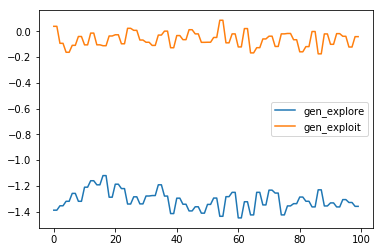

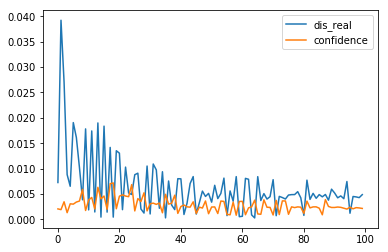

Generation 60  fitness : 95.0
#################################
Measured population fitness : 0s
population fitness : [58. 19. 41. 24. 10.]
mean fit : 30.4
tensor([-0.0608, -0.1685,  0.0806, -0.1685,  0.1423], device='cuda:0')
tensor([ 0.0021, -0.1803,  0.1006, -0.1803,  0.1006],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


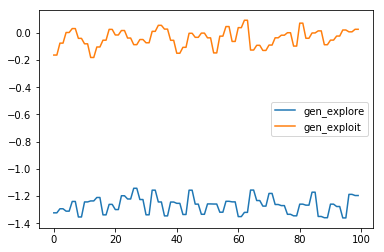

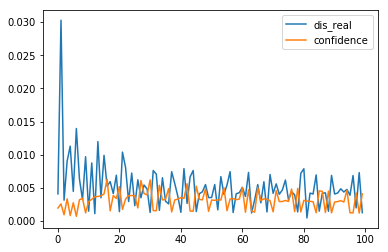

Generation 61  fitness : 58.0
#################################
Measured population fitness : 0s
population fitness : [38. 23. 60. 21.  9.]
mean fit : 30.2
tensor([ 0.2091, -0.1696,  0.0814,  0.0570, -0.0854], device='cuda:0')
tensor([ 0.1249, -0.1807,  0.1437,  0.1249, -0.0810],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


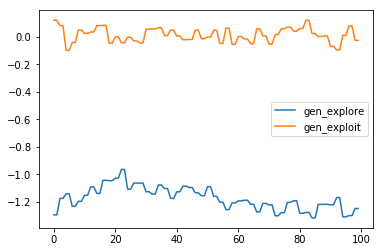

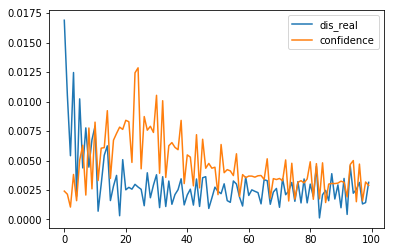

Generation 62  fitness : 60.0
#################################
Measured population fitness : 0s
population fitness : [109.  22.  70.  20.  10.]
mean fit : 46.2
tensor([-0.0959, -0.1798, -0.0879,  0.0555, -0.1724], device='cuda:0')
tensor([-0.0891, -0.1740, -0.0891,  0.2942, -0.1740],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


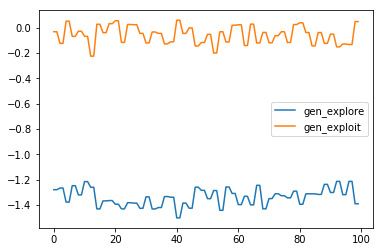

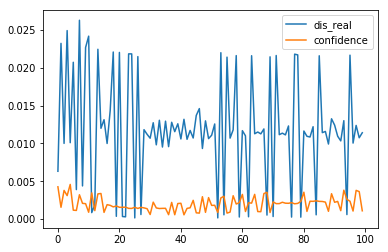

Generation 63  fitness : 109.0
#################################
Measured population fitness : 0s
population fitness : [44. 35. 69. 23. 10.]
mean fit : 36.2
tensor([-0.0728,  0.1041,  0.2854, -0.1742, -0.1742], device='cuda:0')
tensor([-0.0820,  0.3183,  0.2964, -0.1695, -0.1695],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


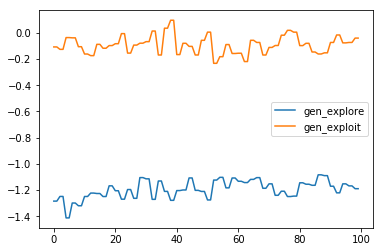

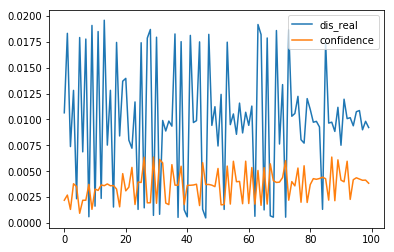

Generation 64  fitness : 69.0
#################################
Measured population fitness : 0s
population fitness : [54. 29. 96. 30. 11.]
mean fit : 44.0
tensor([-0.0155, -0.1693,  0.0284, -0.1768, -0.0242], device='cuda:0')
tensor([-0.0477, -0.1734,  0.0001, -0.1734,  0.0001],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


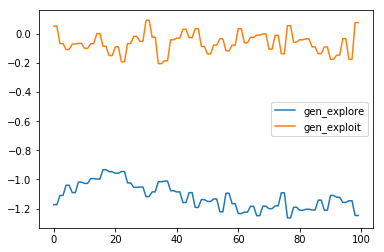

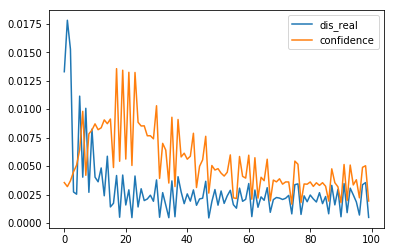

Generation 65  fitness : 96.0
#################################
Measured population fitness : 0s
population fitness : [ 41.  39. 107.  26.  10.]
mean fit : 44.6
tensor([-0.1718,  0.1801,  0.0612, -0.0519, -0.1793], device='cuda:0')
tensor([-0.1799,  0.1211,  0.0098, -0.0418, -0.1799],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


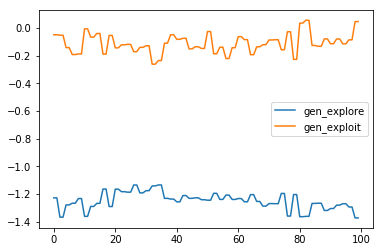

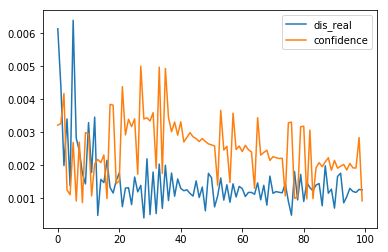

Generation 66  fitness : 107.0
#################################
Measured population fitness : 0s
population fitness : [59. 39. 80. 17. 10.]
mean fit : 41.0
tensor([ 0.0773, -0.1815,  0.2172, -0.1275,  0.5159], device='cuda:0')
tensor([ 0.1523, -0.1792,  0.1523, -0.0872,  0.4402],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


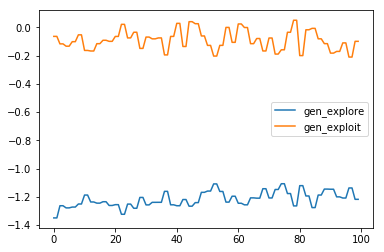

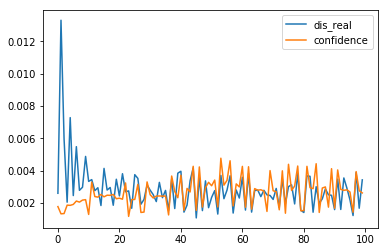

Generation 67  fitness : 80.0
#################################
Measured population fitness : 0s
population fitness : [38. 43. 60. 29.  9.]
mean fit : 35.8
tensor([ 0.3608,  0.2182,  0.0940,  0.0604, -0.1906], device='cuda:0')
tensor([ 0.2826,  0.1235,  0.0686,  0.0686, -0.1939],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


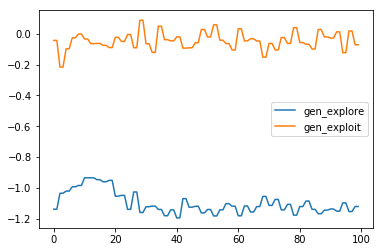

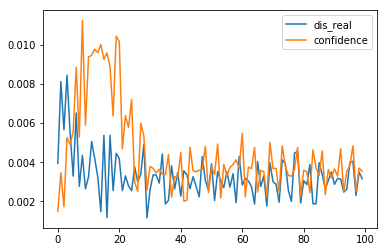

Generation 68  fitness : 60.0
#################################
Measured population fitness : 0s
population fitness : [ 57.  43. 117.  21.   9.]
mean fit : 49.4
tensor([-0.0305, -0.1936, -0.1936,  0.0925,  0.2249], device='cuda:0')
tensor([-0.0606, -0.1894, -0.1894,  0.0975,  0.4046],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


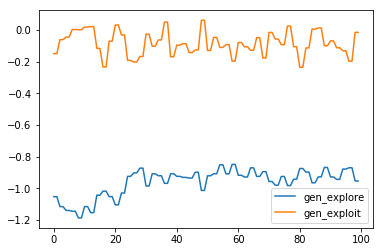

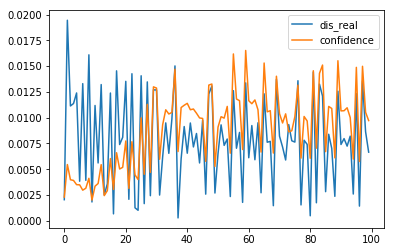

Generation 69  fitness : 117.0
#################################
Measured population fitness : 0s
population fitness : [ 42.  80. 108.  16.  10.]
mean fit : 51.2
tensor([ 0.0824,  0.5262,  0.3612, -0.1424,  0.0908], device='cuda:0')
tensor([ 0.1625,  0.5619,  0.2390, -0.1041,  0.2390],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


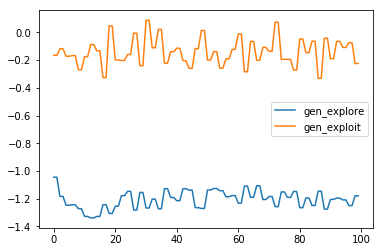

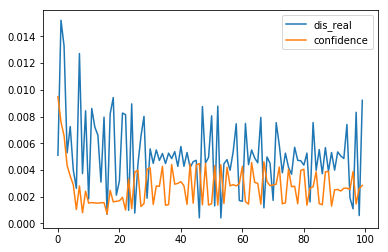

Generation 70  fitness : 108.0
#################################
Measured population fitness : 0s
population fitness : [ 55.  65. 112.  21.   8.]
mean fit : 52.2
tensor([ 0.1857, -0.1923,  0.5488, -0.2074,  0.3613], device='cuda:0')
tensor([ 0.1242, -0.2073,  0.5299, -0.2073,  0.3016],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


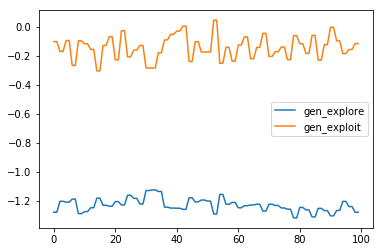

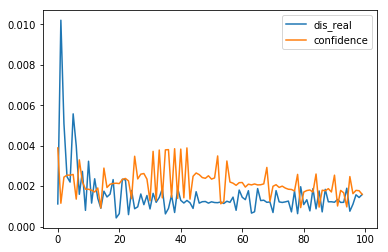

Generation 71  fitness : 112.0
#################################
Measured population fitness : 0s
population fitness : [ 64. 186. 106.  17.  10.]
mean fit : 76.6
tensor([-0.2126,  0.8815,  0.2561,  0.5469,  0.1816], device='cuda:0')
tensor([-0.2133,  0.5666,  0.5666,  0.5271,  0.2095],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


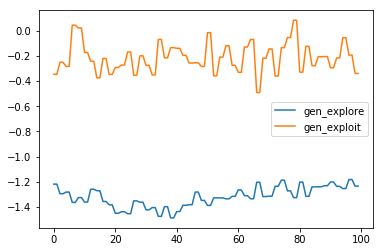

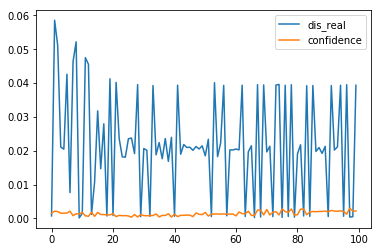

Generation 72  fitness : 186.0
#################################
Measured population fitness : 0s
population fitness : [103. 121. 105.  15.   8.]
mean fit : 70.4
tensor([ 0.5936, -0.2022,  0.2463, -0.1474, -0.1634], device='cuda:0')
tensor([ 0.7566, -0.1949,  0.3925, -0.1391, -0.1391],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


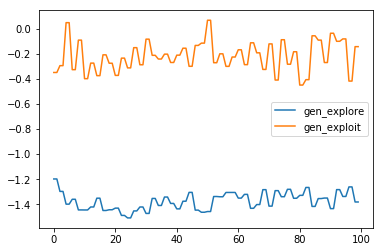

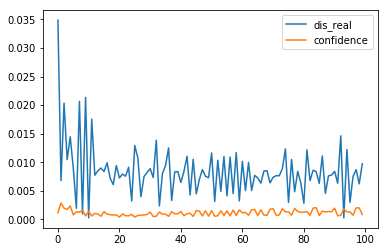

Generation 73  fitness : 121.0
#################################
Measured population fitness : 0s
population fitness : [ 98. 110. 113.  20.   9.]
mean fit : 70.0
tensor([ 0.5068, -0.2219,  0.5510, -0.1680,  0.5346], device='cuda:0')
tensor([ 0.5383, -0.2115,  0.5383, -0.1401,  0.5741],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


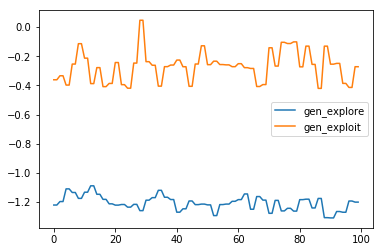

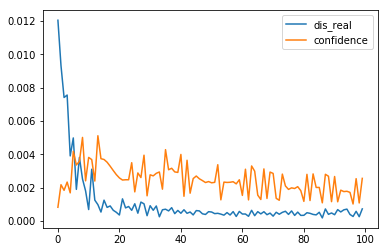

Generation 74  fitness : 113.0
#################################
Measured population fitness : 0s
population fitness : [179. 104. 114.  15.  10.]
mean fit : 84.4
tensor([ 0.5540,  0.5486, -0.1737, -0.2124, -0.2200], device='cuda:0')
tensor([ 0.5515,  0.5515, -0.1485, -0.2103, -0.2103],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


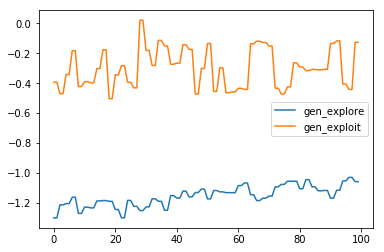

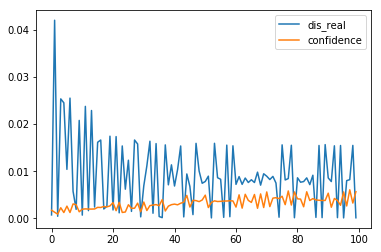

Generation 75  fitness : 179.0
#################################
Measured population fitness : 0s
population fitness : [  66.   92.  120.   25. 2000.]
mean fit : 460.6
tensor([ 0.4062,  0.3005, -0.1026,  0.6658,  0.4332], device='cuda:0')
tensor([0.5834, 0.4854, 0.0653, 0.6160, 0.5834],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


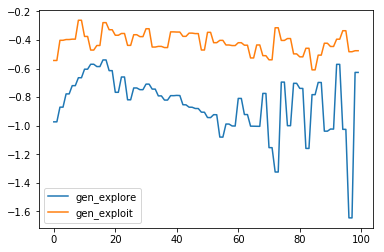

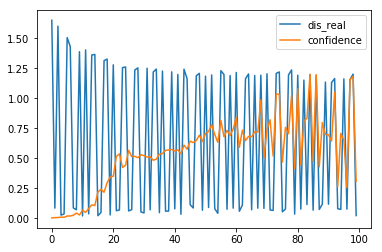

Generation 76  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [  99.  109.  116.   18. 2000.]
mean fit : 468.4
tensor([0.3042, 0.2615, 0.3331, 0.2304, 2.4922], device='cuda:0')
tensor([0.2585, 0.3656, 0.5817, 0.2585, 2.0733],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 1s


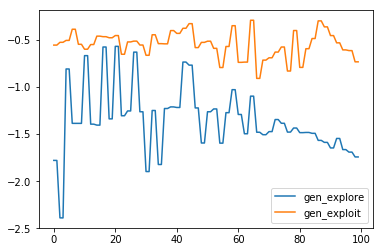

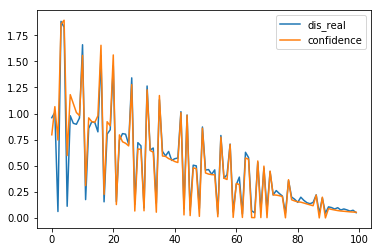

Generation 77  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [ 148.  136.  118.   19. 2000.]
mean fit : 484.2
tensor([ 2.3688,  0.2764,  0.2839, -0.1517,  0.3903], device='cuda:0')
tensor([ 2.3535,  0.2595,  0.2595, -0.1726,  0.2833],
       device='cuda:0', grad_fn=<SelectBackward>)
Trained GAN : 2s


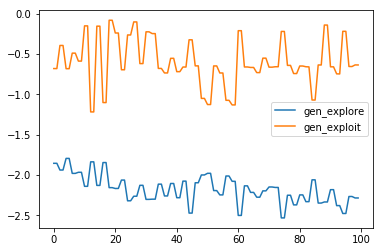

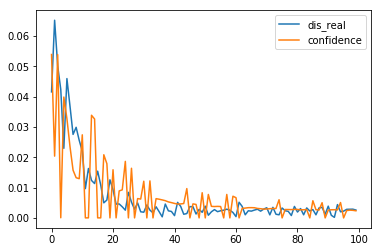

Generation 78  fitness : 2000.0
#################################
Measured population fitness : 0s
population fitness : [ 115.  112.  112.   31. 2000.]
mean fit : 474.0


KeyboardInterrupt: 

In [3]:
population = []
max_population_batch = 2
n_generations = 300
population_size = 5


for p in range(population_size):
    creat = Creature(env.observation_space.shape[0],creature_out_size).to(device)
    #pars = torch.from_numpy(np.random.uniform(0,1,get_params(creat).numel())).type('torch.FloatTensor').to(device)
    pars = torch.tanh(get_params(creat))
    pars = get_params(creat)
    creat = set_params(creat,pars)
    population.append(creat)
    
print("starting training")
creature_size = len(get_params(Creature(env.observation_space.shape[0],creature_out_size)))
print(creature_size)

old_population = []
old_fitnesses = []
all_fitnesses = []

gen = Generator(creature_size,device).to(device)
dis = Discriminator().to(device)


for i in range(n_generations):
    start_time = time.time()
    #reset learning rate decay after every generation
    gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.001,betas=(0.9,0.999))
    dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0001,betas=(0.9,0.999))
    
    #calculate population fitness
    p_fitness_ = measure_population_fitness(population,env,device,discrete_actions,min_reward=-1000000,
                                                             max_steps = 2000)
    print("Measured population fitness : {}s".format(int(time.time() - start_time)))
    
    #Store populations and remove older ones
    old_population.append(population)
    old_fitnesses.append(p_fitness_)
    all_fitnesses.append(p_fitness_)
    
    if len(old_population) > max_population_batch:
        old_population.pop(0)
        old_fitnesses.pop(0)
    
    print("population fitness : {}".format(p_fitness_))
    print("mean fit : {}".format(np.mean(p_fitness_)))   
    
    #define population batch
    population_concat = np.concatenate(np.array(old_population))
    population_batch = []
    for p in population_concat:
        #print(get_params(p))
        population_batch.append(get_params(p))
    population_batch = torch.stack(population_batch, dim=0).to(device)
    
    #define fitness batch
    fitness_batch = np.concatenate(np.array(old_fitnesses))
    fitness_batch_normed = (fitness_batch - np.mean(all_fitnesses))/(np.std(all_fitnesses)+0.000
0001)
    #fitness_batch_normed = (fitness_batch -  np.mean(all_fitnesses))/(np.max(all_fitnesses)-np.min(all_fitnesses))
    fitness_batch_normed = np.log(np.abs(fitness_batch_normed)+1) * (fitness_batch_normed/np.abs(fitness_batch_normed))
    #Train GAN
    start_time = time.time()
    n_epochs = 50
    if i == 0:
        n_epochs = 150
        
    gen_explore_all,gen_exploit_all, dis_loss ,dis_confidence_all= train_gan(population_batch
                                                                                       ,fitness_batch_normed,
              fitness_batch.size,batch_size = 5,n_epochs = n_epochs)
    
    print("Trained GAN : {}s".format(int(time.time() - start_time)))
    
    #Every ten generations show progress
    if i %10 == 0 and i != 0:
        fitness = measure_fitness(population[np.argmax(p_fitness_)],env,device,discrete_actions,min_reward=-100000,
                                  render = True,max_steps = 500)
        
    
    #print(population_batch[population_batch.size(0)  - population_size:].shape,population_batch.shape)
    mutations = gen(population_batch[population_batch.size(0)  - population_size:],lr)
    gen.hidden = None
    
    #Apply mutations
    for idx,p in enumerate(population_batch[population_batch.size(0) - population_size:]):
        child = Creature(env.observation_space.shape[0],creature_out_size) 
        population[idx] = set_params(child,p + mutations[idx])
    
    
    
    plt.plot(gen_explore_all,label='gen_explore')
    plt.plot(gen_exploit_all,label='gen_exploit')
    plt.legend()
    plt.show()
    plt.plot(dis_loss,label='dis_real')
    plt.plot(dis_confidence_all,label='confidence')
    #plt.ylim(0,5)
    plt.legend()
    plt.show()
    
    print("Generation {}  fitness : {}".format(i+1,np.max(p_fitness_)))
    print("#################################")